In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

from keras import models
from keras import layers
from tensorflow import keras
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
train.head(10)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
5,5,1.025,6.90,947,28.4,395,2.64,1
6,6,1.008,5.09,371,15.5,159,2.17,1
7,7,1.015,5.53,450,8.1,170,1.16,0
8,8,1.025,7.38,736,25.3,418,1.52,0
9,9,1.017,6.61,527,20.0,75,4.49,1


Ok, binary classification quest with metric based on confusion matrix.
Some features are different, so i'll use standart scaler.

In [2]:
target = train['target']

del train['id']
del train['target']

scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train),
                     columns = train.columns)
train.head(5)

,gravity,ph,osmo,cond,urea,calc
0,-0.734032,0.365623,-0.889728,-0.884388,-1.134869,-0.829136
1,1.065904,-0.865897,0.219521,0.288059,0.846384,0.020338
2,-1.334010,0.272090,-1.196904,0.407969,-0.878040,1.532589
3,0.465925,-1.629751,-0.893994,-0.084992,0.875736,0.782687
4,0.465925,-0.663242,0.949065,-0.484690,0.780342,-0.592652


Visualization, maybe some features could be groupped by dimensionality reduction by PCA

array([[<AxesSubplot:xlabel='gravity', ylabel='gravity'>,
        <AxesSubplot:xlabel='ph', ylabel='gravity'>,
        <AxesSubplot:xlabel='osmo', ylabel='gravity'>,
        <AxesSubplot:xlabel='cond', ylabel='gravity'>,
        <AxesSubplot:xlabel='urea', ylabel='gravity'>,
        <AxesSubplot:xlabel='calc', ylabel='gravity'>],
       [<AxesSubplot:xlabel='gravity', ylabel='ph'>,
        <AxesSubplot:xlabel='ph', ylabel='ph'>,
        <AxesSubplot:xlabel='osmo', ylabel='ph'>,
        <AxesSubplot:xlabel='cond', ylabel='ph'>,
        <AxesSubplot:xlabel='urea', ylabel='ph'>,
        <AxesSubplot:xlabel='calc', ylabel='ph'>],
       [<AxesSubplot:xlabel='gravity', ylabel='osmo'>,
        <AxesSubplot:xlabel='ph', ylabel='osmo'>,
        <AxesSubplot:xlabel='osmo', ylabel='osmo'>,
        <AxesSubplot:xlabel='cond', ylabel='osmo'>,
        <AxesSubplot:xlabel='urea', ylabel='osmo'>,
        <AxesSubplot:xlabel='calc', ylabel='osmo'>],
       [<AxesSubplot:xlabel='gravity', ylabel='cond'

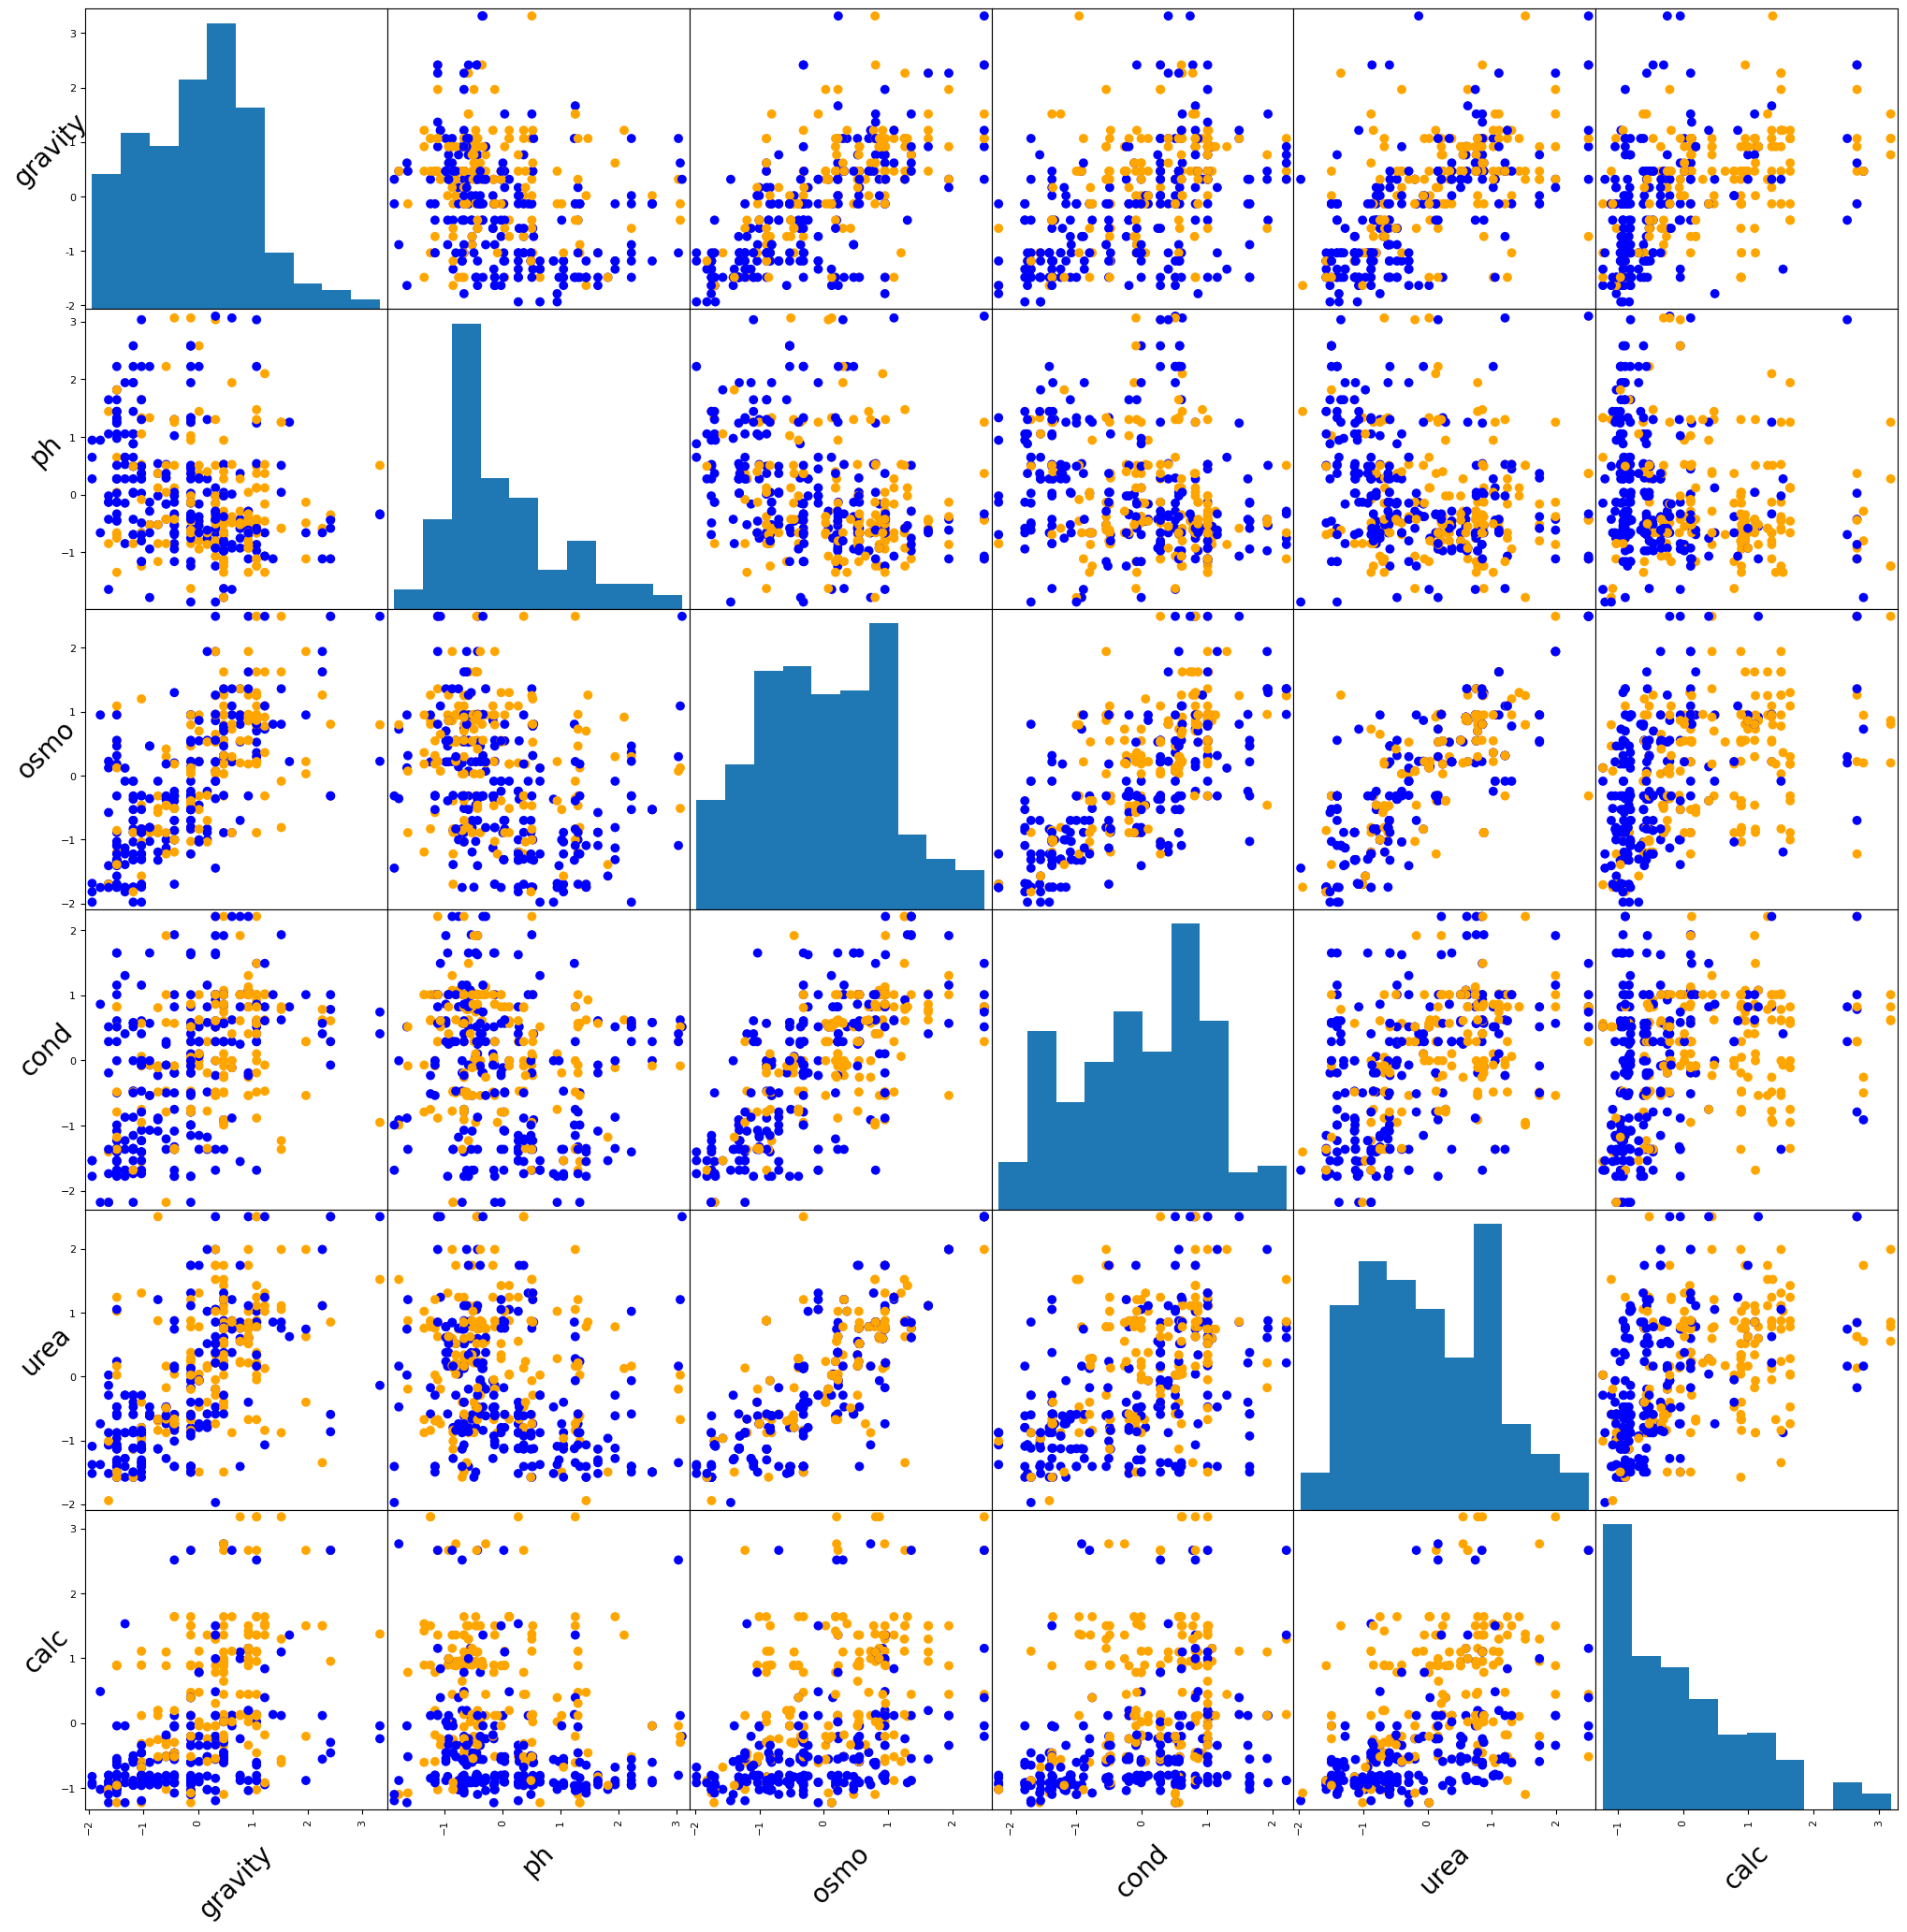

In [3]:
colors = {1: 'orange', 0: 'blue'}

def visual(df):
    
    scatter_matrix = pd.plotting.scatter_matrix(
                     df, s = 50, alpha = 1, 
                     figsize = (25, 25), grid = True, 
                     marker = 'o', c = target.map(colors)) 

    for ax in scatter_matrix.ravel():
        ax.set_xlabel(ax.get_xlabel(),
                      fontsize = 20,
                      rotation = 45)
        ax.set_ylabel(ax.get_ylabel(),
                      fontsize = 20,
                      rotation = 45)
    return scatter_matrix

visual(train)

Oh, it so similar and mixed... Should be difficult, no way to use PCA. Let's see correlation heatmap 

          gravity        ph      osmo      cond      urea      calc
gravity  1.000000 -0.290349  0.692317  0.470433  0.631710  0.494304
ph      -0.290349  1.000000 -0.309495 -0.190185 -0.279749 -0.214402
osmo     0.692317 -0.309495  1.000000  0.708480  0.809880  0.472114
cond     0.470433 -0.190185  0.708480  1.000000  0.499109  0.330609
urea     0.631710 -0.279749  0.809880  0.499109  1.000000  0.489879
calc     0.494304 -0.214402  0.472114  0.330609  0.489879  1.000000


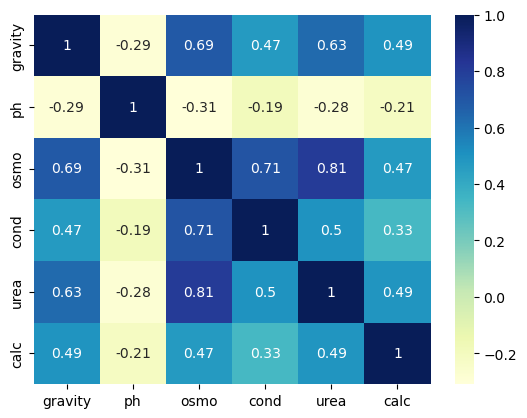

In [4]:
print(train.corr())
  
dataplot = sb.heatmap(train.corr(),
                      cmap="YlGnBu",
                      annot = True)
x_train, x_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.2,
                                                    random_state = 17)
x_train 
plt.show()

I will train models on the most difficult pair, with coldest correlation

In [5]:
def result(model):
    
    pred = model.predict(x_test)
    accuracy = confusion_matrix(y_test, pred)
    print(f'{accuracy}')

    colors = {1: 'orange', 0: 'blue'}
    
    a = plt.scatter(x_test['gravity'], x_test['ph'],
                    s = 25, alpha = 1, marker = 'o', c = pred)
    plt.show(a)

    b = plt.scatter(x_test['gravity'], x_test['ph'],
                    s = 25, alpha = 1, marker = 'o', c = y_test)
    plt.show(b)

CatBoost - 81.92%

[[41  8]
 [ 7 27]]


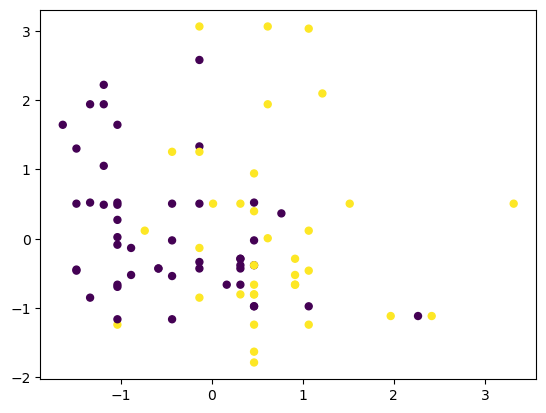

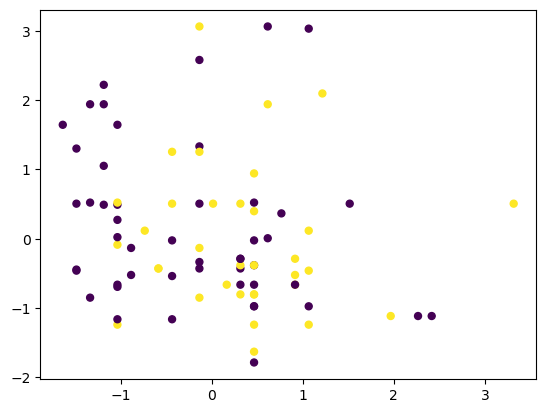

In [6]:
model_0 = CatBoostClassifier(
    iterations = 1000, 
    learning_rate = 0.02,
    random_seed = 43,
    ).fit(
    x_train, y_train,
    eval_set = (x_test, y_test),
    verbose = False,
    )
result(model_0) 

K-Neighbors - 80.72%

[[40  9]
 [ 7 27]]


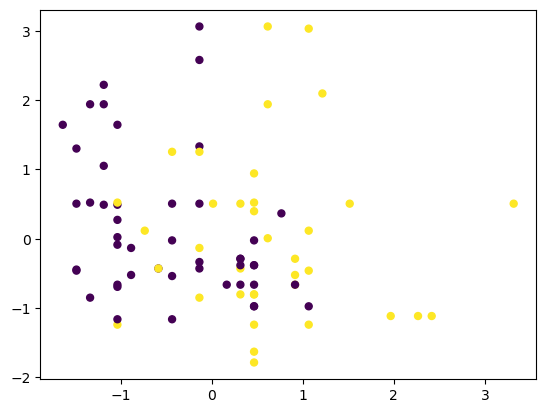

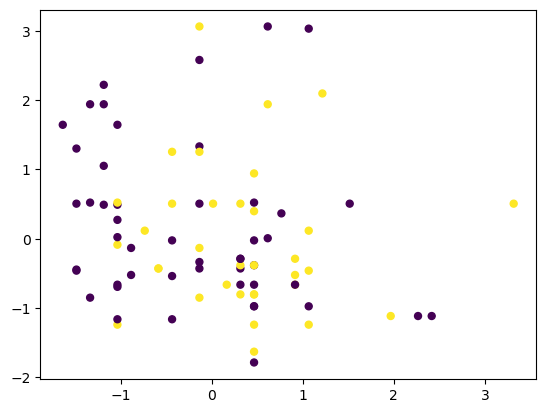

In [7]:
model_1 = KNeighborsClassifier(n_neighbors = 17).fit(x_train, y_train)

result(model_1)

Random Forest - 83.13%

[[43  6]
 [ 8 26]]


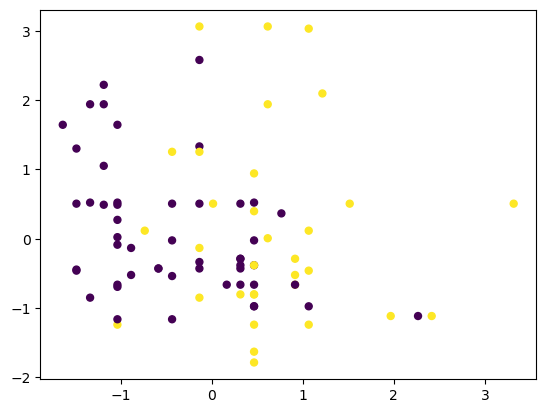

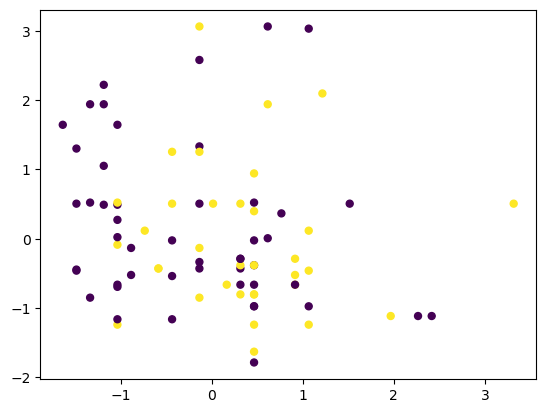

In [8]:
model_2 = RandomForestClassifier(n_estimators = 2000,     
                                 criterion='gini',
                                 max_depth = 25,                    
                                 max_features = None,
                                 min_weight_fraction_leaf = 0.015,
                                 random_state = 1337,
                                 ).fit(x_train, y_train)
result(model_2)

Dense NN - 86.75% - i will use that model for making submission

Epoch 1/37
42/42 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.5770
Epoch 2/37
42/42 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.6737
Epoch 3/37
42/42 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6798
Epoch 4/37
42/42 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6798
Epoch 5/37
42/42 [==============================] - 0s 2ms/step - loss: 0.6199 - accuracy: 0.7130
Epoch 6/37
42/42 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.7100
Epoch 7/37
42/42 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.7221
Epoch 8/37
42/42 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.7100
Epoch 9/37
42/42 [==============================] - 0s 3ms/step - loss: 0.5830 - accuracy: 0.7372
Epoch 10/37
42/42 [==============================] - 0s 2ms/step - loss: 0.5801 - accuracy: 0.7281
Epoch 11/37
42/42 [

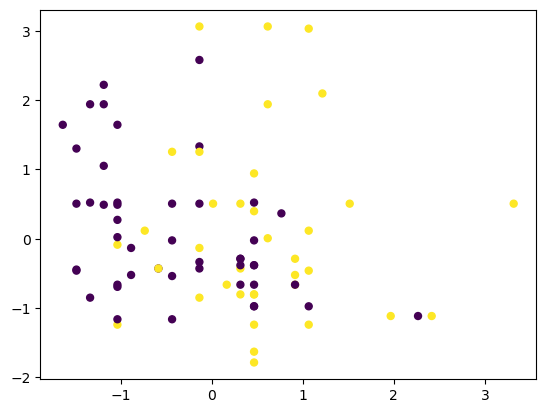

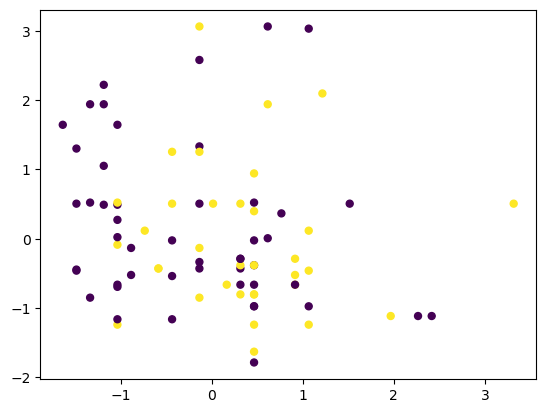

In [9]:
model = keras.Sequential([
        layers.Dense(256, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(64, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
        ])

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
model.compile(optimizer = optimizer,
             loss = "binary_crossentropy",
             metrics = ["accuracy"]
             )
model.fit(x_train, y_train,
          epochs = 37, batch_size = 8)

pred = np.round(model.predict(x_test))
accuracy = confusion_matrix(y_test, pred)
print(f'{accuracy}')

a = plt.scatter(x_test['gravity'], x_test['ph'],
            s = 25, alpha = 1, marker = 'o', c = pred)
plt.show(a)

b = plt.scatter(x_test['gravity'], x_test['ph'],
            s = 25, alpha = 1, marker = 'o', c = y_test)
plt.show(b)

In [10]:
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')

del test['id']

scaler = StandardScaler()
test = pd.DataFrame(scaler.fit_transform(test),
                    columns = test.columns)
test.head(10)

,gravity,ph,osmo,cond,urea,calc
0,-0.202805,-1.153899,-1.313470,-1.416467,-0.958051,-0.946130
1,0.254749,-0.427877,0.928689,0.970087,0.772576,-0.200085
2,0.864821,-0.955893,0.182716,-0.325471,0.542321,2.894380
3,0.254749,-1.005394,0.055561,0.465502,-0.215292,-0.200085
4,-1.117912,-0.114368,-0.372526,0.970087,1.307362,-0.556889
5,0.712303,-0.279372,0.398878,-0.257283,0.772576,0.134013
6,-0.507840,0.001136,-0.821805,-0.611857,-0.638665,-0.047633
7,0.864821,-0.675384,2.463021,0.970087,2.518058,2.790582
8,-1.270430,1.403678,-1.750034,-1.457379,-1.611678,-1.111558
9,-2.033019,2.080198,-0.482727,-0.557307,-0.638665,-0.988298


In [11]:
prediction = model.predict(test)

submission = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
submission = pd.DataFrame(submission['id'])
target = pd.DataFrame(data = prediction, 
                     columns = ['target'])
submission = pd.concat([submission, target], axis = 1)
submission.to_csv('/kaggle/working/submission.csv', index = False)
submission.head(5)

9/9 [==============================] - 0s 2ms/step


,id,target
0,414,0.165462
1,415,0.403051
2,416,0.922380
3,417,0.456185
4,418,0.320050
